![](imagegeneratedbyai.png)

Imagine living in a house where every single watt of electricity you use is meticulously recorded, each of which contributes to a vast pool of data. By analyzing this detailed household power consumption data recorded over nearly 4 years, an energy company can help customers achieve sustainable energy usage while balancing their energy generation. With predictive models, the company can optimize energy usage, forecast future consumption, and provide tailored recommendations. Your task is to use this dataset to build a model that predicts power consumption, benefiting both the energy provider and its customers.

## The Data

Available in `df_train.csv` and `df_test.csv`:

| Column             | Type   | Description                                                                 |
|--------------------|--------|----------------------------------------------------------------------------|
| date               | chr    | Date of the measurement                                                    |
| power_consumption  | dbl    | Daily power consumption (in kilowatts)                                     |
| year               | int    | Year of the measurement                                                    |
| semester           | int    | Semester of the measurement (1 for Jan-Jun, 2 for Jul-Dec)                 |
| quarter            | int    | Quarter of the measurement (1 for Q1, 2 for Q2, 3 for Q3, 4 for Q4)        |
| day_in_week        | chr    | Day of the week of the measurement (e.g., Monday, Tuesday)                 |
| week_in_year       | int    | Week number in the year of the measurement                                 |
| day_in_year        | int    | Day number in the year of the measurement                                  |
| month              | int    | Month of the year of the measurement                                       |

This dataset was donated to the UCI Machine Learning Repository. For detailed information about the dataset and the preprocessing steps, please refer to the [License and Data Preprocessing Details](License.ipynb) notebook.

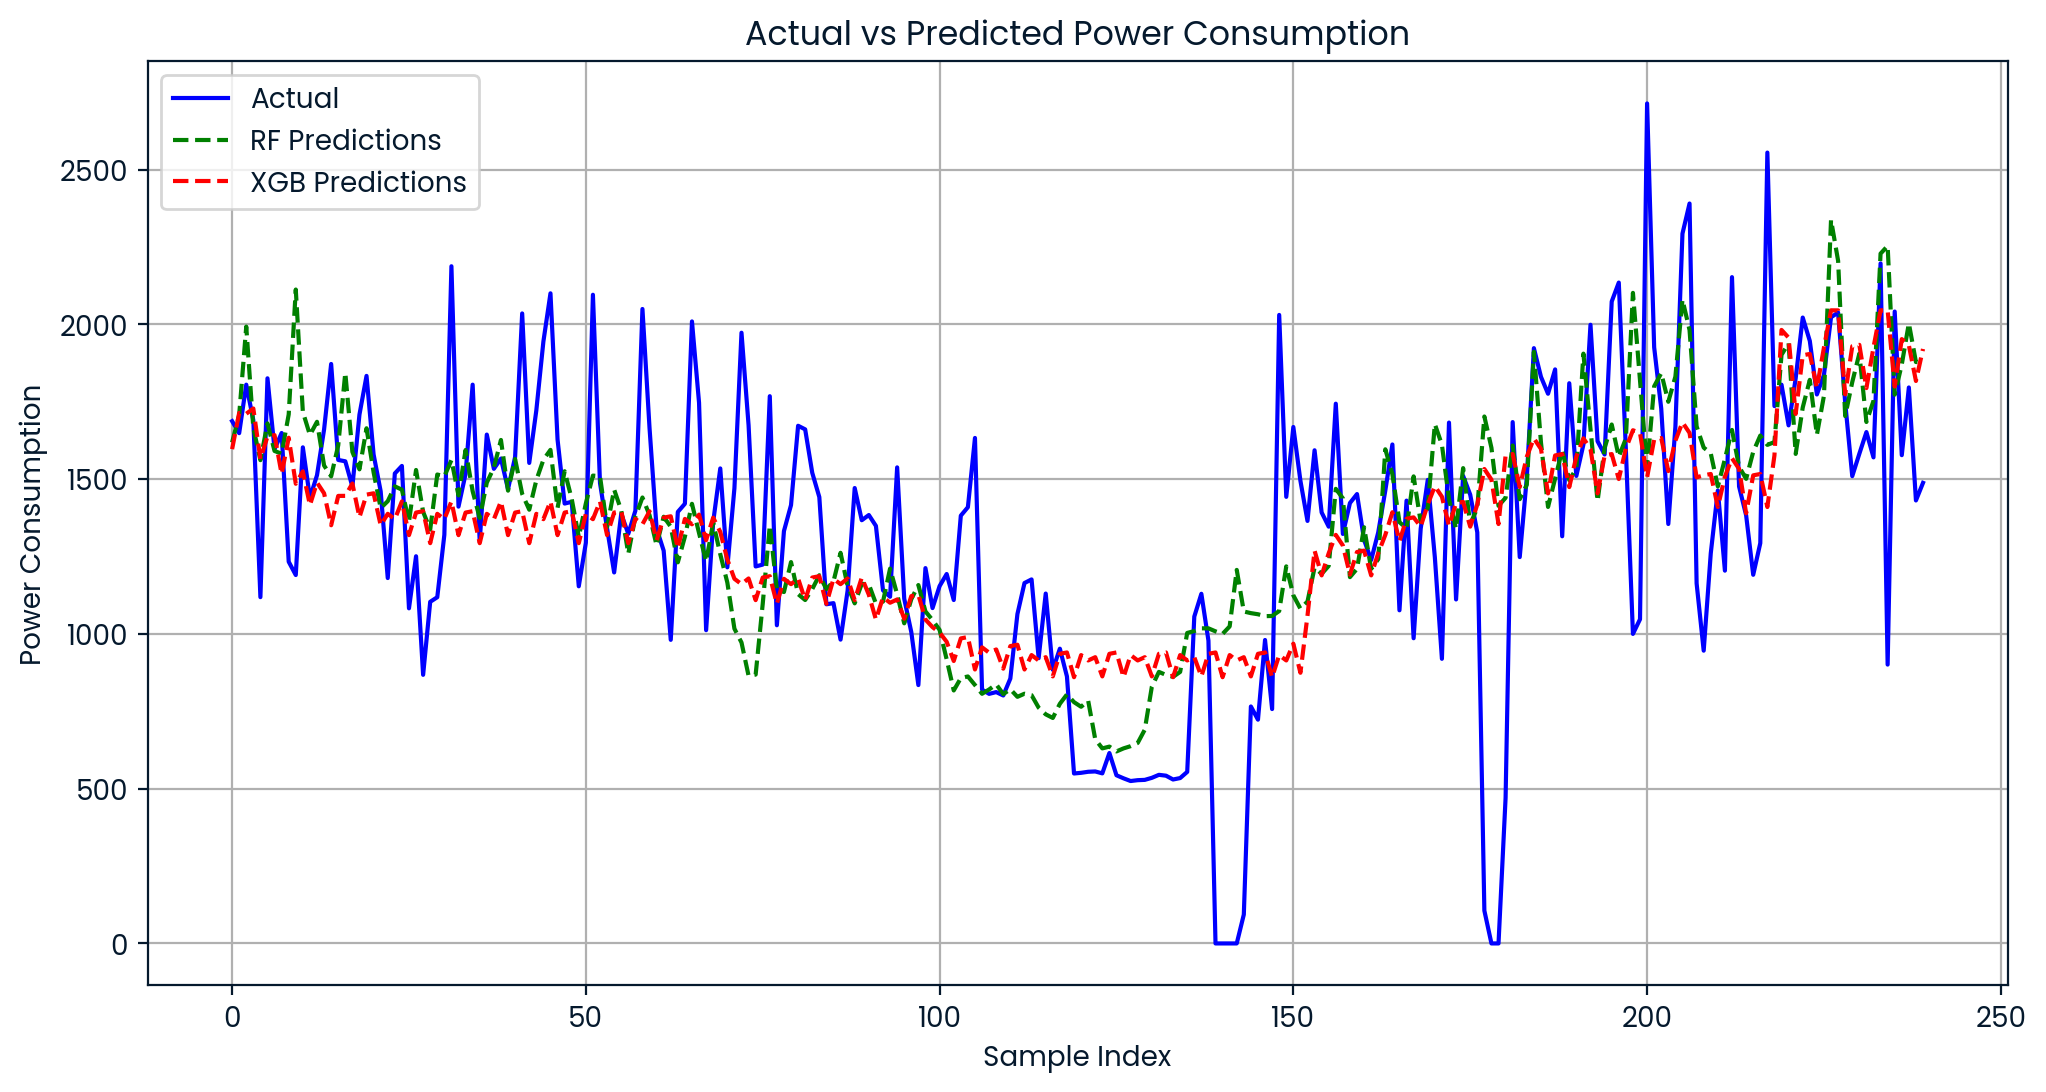

Pearson's Correlation (Random Forest): 0.57
Pearson's Correlation (XGBoost): 0.58
Lowest RMSE: XGBoost -> 394.67
Trend follows: Yes


In [5]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error

# DATA WRANGLING

# Function to clean the dataset 
def df_prep(df):
    # CLEANING THE DATA
    # Converting data types
    df['date'] = pd.to_datetime(df['date'])                         # Converts date column to "Date" datatype.
    df['day_in_week'] = df['day_in_week'].astype('category')        # Converts day_in_week column to "category" datatype.
    
    # One-hot encoding of categorical variables
    df = pd.get_dummies(df, columns=['day_in_week'], dtype=int, drop_first=True) 
    
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    # DATASET PREPARATION
    # Separate features and target variable
    X = df.iloc[:,2:]
    Y = df['power_consumption']

    return X, Y

# Preparing Training and Testing Datasets
X_train, Y_train = df_prep(df_train)
X_test, Y_test = df_prep(df_test)

# TRAINING THE MODELS

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Train Random Forest model
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_root_mean_squared_error')
rf_grid.fit(X_train, Y_train)
best_rf_model = rf_grid.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rmse_rf = round(np.sqrt(mean_squared_error(Y_test, y_pred_rf)), 2)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=3, scoring='neg_root_mean_squared_error')
xgb_grid.fit(X_train, Y_train)
best_xgb_model = xgb_grid.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
rmse_xgb = round(np.sqrt(mean_squared_error(Y_test, y_pred_xgb)), 2)

# Determine lowest RMSE between the two models
selected_rmse = min(rmse_rf, rmse_xgb)

# MODEL PREDICTION AND RMSE

# Plot actual vs. predicted power consumption
plt.figure(figsize=(12, 6))
plt.plot(Y_test.values, label="Actual", color='blue')
plt.plot(y_pred_rf, label="RF Predictions", linestyle='dashed', color='green')
plt.plot(y_pred_xgb, label="XGB Predictions", linestyle='dashed', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Power Consumption")
plt.legend()
plt.title("Actual vs Predicted Power Consumption")
plt.grid()
plt.show()

# Additional analysis
correlation_rf = round(np.corrcoef(Y_test, y_pred_rf)[0, 1],2)
correlation_xgb = round(np.corrcoef(Y_test, y_pred_xgb)[0, 1],2)

# Determine trend similarity
trend_similarity = "Yes" if (selected_rmse < 450) else "No"
trend_model = "Random Forest" if (correlation_rf > correlation_xgb) else "XGBoost"

# Print results
print(f"Pearson's Correlation (Random Forest): {correlation_rf}")
print(f"Pearson's Correlation (XGBoost): {correlation_xgb}")
print(f"Lowest RMSE: {trend_model} -> {selected_rmse}")
print(f"Trend follows: {trend_similarity}")